In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # or from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
# from sklearn.preprocessing import SimpleImputer # To check for missing values
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

%matplotlib inline 
import matplotlib.pyplot as plt 

In [2]:
data = pd.read_csv('Tumor_data.csv')
data.shape

(569, 33)

In [3]:
# Check for duplicate rows
dup_rows = data[data.duplicated(keep = 'last')]

dup_rows

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32


In [4]:
data['diagnosis'].unique()

array(['M', 'B'], dtype=object)

In [5]:
data['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [6]:
#checking for null values
data.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

# Unnamed: 32 has all null values, and wil be dropped since it is missing a huge percentage of its values

# 'id' column is also irrelevant and will be dropped

In [7]:
data.drop(columns = ['id' ,'Unnamed: 32'], inplace = True)

In [8]:
# Map the diagnosis to binary values
data['diagnosis'] = data['diagnosis'].map({'M':1, 'B':0})

In [9]:
data['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [10]:
# Account for class imbalance using up-sample minority class i.e randomly duplicating observations from the minority 
# class to reinforce its signal
# 1. Resample with replacement

from sklearn.utils import resample


Next, we’ll create a new DataFrame with an up-sampled minority class, using the following steps:

First, we’ll separate observations from each class into different DataFrames.
Next, we’ll resample the minority class with replacement, setting the number of samples to match that of the majority class.
Finally, we’ll combine the up-sampled minority class DataFrame with the original majority class DataFrame.

In [11]:
# Separate majority and minority classes
data_majority = data[data.diagnosis==0]
data_minority = data[data.diagnosis==1]
 
# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=357,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled])
 
# Display new class counts
data_upsampled.diagnosis.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

0    357
1    357
Name: diagnosis, dtype: int64

In [12]:
data_upsampled

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
19,0,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.047810,0.1885,...,15.110,19.26,99.70,711.2,0.14400,0.17730,0.23900,0.12880,0.2977,0.07259
20,0,13.080,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.031100,0.1967,...,14.500,20.49,96.09,630.5,0.13120,0.27760,0.18900,0.07283,0.3184,0.08183
21,0,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.020760,0.1815,...,10.230,15.66,65.13,314.9,0.13240,0.11480,0.08867,0.06227,0.2450,0.07773
37,0,13.030,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.029230,0.1467,...,13.300,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169
46,0,8.196,16.84,51.71,201.9,0.08600,0.05943,0.01588,0.005917,0.1769,...,8.964,21.96,57.26,242.2,0.12970,0.13570,0.06880,0.02564,0.3105,0.07409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,1,19.680,21.68,129.90,1194.0,0.09797,0.13390,0.18630,0.110300,0.2082,...,22.750,34.66,157.60,1540.0,0.12180,0.34580,0.47340,0.22550,0.4045,0.07918
141,1,16.110,18.05,105.10,813.0,0.09721,0.11370,0.09447,0.059430,0.1861,...,19.920,25.27,129.00,1233.0,0.13140,0.22360,0.28020,0.12160,0.2792,0.08158
321,1,20.160,19.66,131.10,1274.0,0.08020,0.08564,0.11550,0.077260,0.1928,...,23.060,23.03,150.20,1657.0,0.10540,0.15370,0.26060,0.14250,0.3055,0.05933
283,1,16.240,18.77,108.80,805.1,0.10660,0.18020,0.19480,0.090520,0.1876,...,18.550,25.09,126.90,1031.0,0.13650,0.47060,0.50260,0.17320,0.2770,0.10630


In [13]:
# Check for duplicate rows
duplicate_rows = data_upsampled[data_upsampled.duplicated(keep = 'last')]

In [14]:
duplicate_rows

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
210,1,20.58,22.14,134.70,1290.0,0.09090,0.13480,0.16400,0.09561,0.1765,...,23.24,27.84,158.3,1656.0,0.1178,0.2920,0.3861,0.1920,0.2909,0.05865
253,1,17.30,17.08,113.00,928.2,0.10080,0.10410,0.12660,0.08353,0.1813,...,19.85,25.09,130.9,1222.0,0.1416,0.2405,0.3378,0.1857,0.3138,0.08113
105,1,13.11,15.56,87.21,530.2,0.13980,0.17650,0.20710,0.09601,0.1925,...,16.31,22.40,106.4,827.2,0.1862,0.4099,0.6376,0.1986,0.3147,0.14050
193,1,12.34,26.86,81.15,477.4,0.10340,0.13530,0.10850,0.04562,0.1943,...,15.65,39.34,101.7,768.9,0.1785,0.4706,0.4425,0.1459,0.3215,0.12050
17,1,16.13,20.68,108.10,798.8,0.11700,0.20220,0.17220,0.10280,0.2164,...,20.96,31.48,136.8,1315.0,0.1789,0.4233,0.4784,0.2073,0.3706,0.11420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1,14.45,20.22,94.49,642.7,0.09872,0.12060,0.11800,0.05980,0.1950,...,18.33,30.12,117.9,1044.0,0.1552,0.4056,0.4967,0.1838,0.4753,0.10130
368,1,21.71,17.25,140.90,1546.0,0.09384,0.08562,0.11680,0.08465,0.1717,...,30.75,26.44,199.5,3143.0,0.1363,0.1628,0.2861,0.1820,0.2510,0.06494
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
156,1,17.68,20.74,117.40,963.7,0.11150,0.16650,0.18550,0.10540,0.1971,...,20.47,25.11,132.9,1302.0,0.1418,0.3498,0.3583,0.1515,0.2463,0.07738


In [15]:
rows, cols = data_upsampled.shape
print(f'The dataset now contains {rows} rows and {cols} columns')


The dataset now contains 714 rows and 31 columns


<AxesSubplot:>

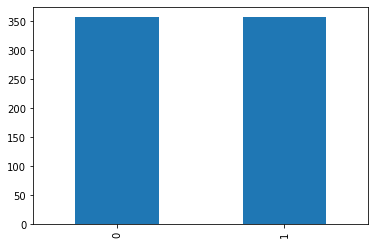

In [16]:
data_upsampled['diagnosis'].value_counts().plot(kind = 'bar')

In [17]:
#split the data into training and testing sets
X = data_upsampled.drop(columns = 'diagnosis')

y = data_upsampled['diagnosis']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [19]:
lrmodel = LogisticRegression(solver='liblinear',multi_class='ovr')
lrmodel.fit(X_train, y_train)
lrmodel.score(X_test, y_test)


0.9720670391061452

In [20]:
predictions = lrmodel.predict(X_test)

In [21]:
cm = confusion_matrix(y_test, predictions)
cm

array([[93,  0],
       [ 5, 81]], dtype=int64)

Text(69.0, 0.5, 'Actual')

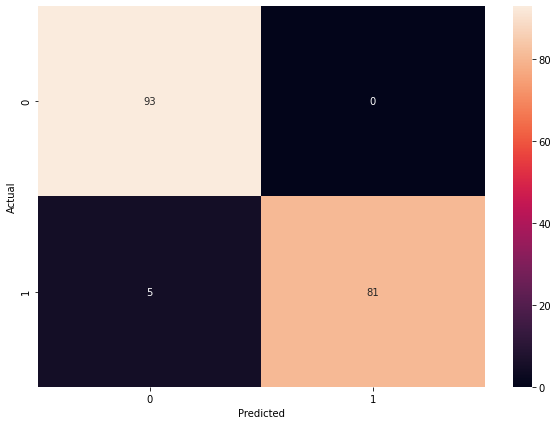

In [22]:
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [23]:
print('Classification report is : \n', classification_report(y_test, predictions))

Classification report is : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        93
           1       1.00      0.94      0.97        86

    accuracy                           0.97       179
   macro avg       0.97      0.97      0.97       179
weighted avg       0.97      0.97      0.97       179



# Recall confusion matrix : 
## True positve     ;      False positive
##  False negative   ;   True Negative

In [24]:
# Checking if variance of some features are multiple folds of the others
X_var = np.var(X_train, axis = 0)

In [25]:
X_var

radius_mean                    14.645897
texture_mean                   17.895234
perimeter_mean                695.569444
area_mean                  159479.349548
smoothness_mean                 0.000209
compactness_mean                0.003432
concavity_mean                  0.007347
concave points_mean             0.001743
symmetry_mean                   0.000781
fractal_dimension_mean          0.000064
radius_se                       0.109145
texture_se                      0.259024
perimeter_se                    5.891398
area_se                      3349.774872
smoothness_se                   0.000008
compactness_se                  0.000379
concavity_se                    0.000801
concave points_se               0.000038
symmetry_se                     0.000079
fractal_dimension_se            0.000007
radius_worst                   27.530790
texture_worst                  37.908863
perimeter_worst              1331.423158
area_worst                 417490.652131
smoothness_worst

In [26]:
# The dataset needs to be standardized, judging from the results above
# Standardizing the data from sklearn.prerocessing
StdS = StandardScaler() # SScaler = preprocessing.StandardScaler().fit(X_train)
Std_X_train = StdS.fit_transform(X_train) # Std_X_train = SScaler.transform(X_train)
Std_X_test = StdS.transform(X_test) # Std_X_test = SScaler.transform(X_test)

In [27]:
X_var2 = np.var(Std_X_train, axis = 0)

X_var2

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

We can fit a LogisticRegression model on the regression dataset and retrieve the coeff_ property that contains the coefficients found for each input variable.

These coefficients can provide the basis for a crude feature importance score. This assumes that the input variables have the same scale or have been scaled prior to fitting a model.

Running the example fits the model, then reports the coefficient value for each feature.

Recall this is a classification problem with classes 0 and 1. Notice that the coefficients are both positive and negative. The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.

A bar chart is then created for the feature importance scores.
Now that we have seen the use of coefficients as importance scores

In [28]:
features = data.columns[1:]
len(features)

30

# Logistic Regression does not have any critical hyperparameters to tune
# I tried both the 'liblinear' for large dataset, and 'lbfgs'  for small dataset, solvers(regularizers) and got the exact same evaluation performance results

In [29]:
# define the model
model2 = LogisticRegression(solver='liblinear',multi_class='ovr')
# fit the model
model2.fit(Std_X_train, y_train)
# get importance
importance = model2.coef_[0]
# summarize feature importance
predictions2 = model2.predict(Std_X_test)

Text(69.0, 0.5, 'Actual')

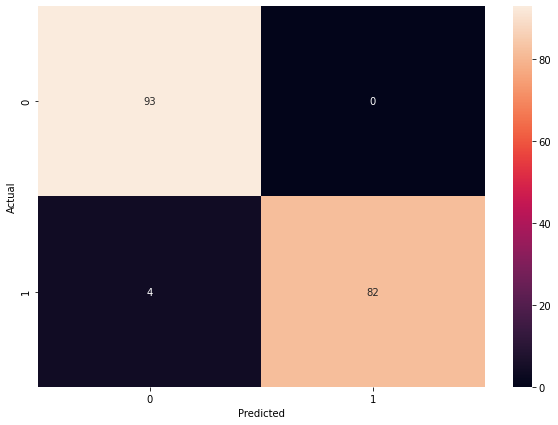

In [30]:
cm1 = confusion_matrix(y_test, predictions2)

plt.figure(figsize=(10,7))
sn.heatmap(cm1, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [31]:
print('Accuracy is :', accuracy_score(y_test, predictions2))
print('')
print('Classification report is : \n', classification_report(y_test, predictions2))

Accuracy is : 0.9776536312849162

Classification report is : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        93
           1       1.00      0.95      0.98        86

    accuracy                           0.98       179
   macro avg       0.98      0.98      0.98       179
weighted avg       0.98      0.98      0.98       179



In [32]:
# Getting the feature importances
for i,v in zip(features, importance):
    print('Feature:'+ str(i), v)

Feature:radius_mean 0.4537428960286966
Feature:texture_mean 0.6934052148786408
Feature:perimeter_mean 0.40434798809170097
Feature:area_mean 0.4547825460131695
Feature:smoothness_mean 0.7363646665345003
Feature:compactness_mean -0.5176370843978338
Feature:concavity_mean 0.6296330271453721
Feature:concave points_mean 1.041644237866311
Feature:symmetry_mean -0.4431946112841907
Feature:fractal_dimension_mean -0.4307866454953537
Feature:radius_se 1.4749376555038247
Feature:texture_se 0.27436794189797203
Feature:perimeter_se 1.0002167704946168
Feature:area_se 0.8166787073461672
Feature:smoothness_se -0.18940238096536735
Feature:compactness_se -0.34152372126728586
Feature:concavity_se 0.007443975635514585
Feature:concave points_se 0.6055276835965374
Feature:symmetry_se -0.3155029638096485
Feature:fractal_dimension_se -0.6763495288549969
Feature:radius_worst 0.9140593147470099
Feature:texture_worst 0.7620051676170599
Feature:perimeter_worst 0.8210031514288072
Feature:area_worst 0.7406525011678

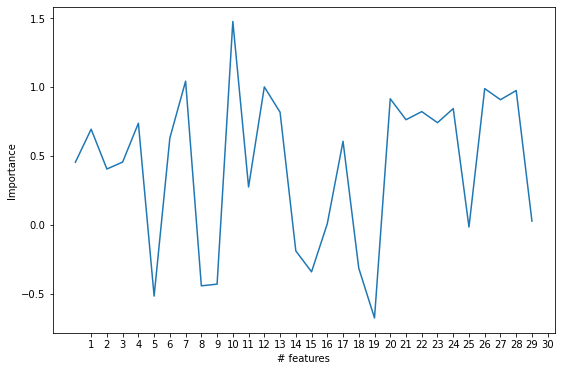

In [33]:
# Plot the feature importance
fig, sub = plt.subplots(1, 1)
fig.set_size_inches(9, 6)
plt.plot([x for x in range(len(importance))], importance)
plt.xlabel('# features')
plt.ylabel('Importance')
plt.xticks(range(1,31))
plt.show()

Now to remove the 10 least important feature according to the coefficient

In [34]:
ndata = {}
for i,v in zip(features, importance):
    ndata[v] = i
print(ndata)

{0.4537428960286966: 'radius_mean', 0.6934052148786408: 'texture_mean', 0.40434798809170097: 'perimeter_mean', 0.4547825460131695: 'area_mean', 0.7363646665345003: 'smoothness_mean', -0.5176370843978338: 'compactness_mean', 0.6296330271453721: 'concavity_mean', 1.041644237866311: 'concave points_mean', -0.4431946112841907: 'symmetry_mean', -0.4307866454953537: 'fractal_dimension_mean', 1.4749376555038247: 'radius_se', 0.27436794189797203: 'texture_se', 1.0002167704946168: 'perimeter_se', 0.8166787073461672: 'area_se', -0.18940238096536735: 'smoothness_se', -0.34152372126728586: 'compactness_se', 0.007443975635514585: 'concavity_se', 0.6055276835965374: 'concave points_se', -0.3155029638096485: 'symmetry_se', -0.6763495288549969: 'fractal_dimension_se', 0.9140593147470099: 'radius_worst', 0.7620051676170599: 'texture_worst', 0.8210031514288072: 'perimeter_worst', 0.7406525011678374: 'area_worst', 0.842959499896238: 'smoothness_worst', -0.016599570297001737: 'compactness_worst', 0.987613

In [35]:
import copy

In [36]:
dcopy = copy.deepcopy(ndata)
for i in range(0, 10):
     del dcopy[min(dcopy)]

In [37]:
# The 20 most significant features and their importance score
print(len(dcopy))
dcopy

20


{0.4537428960286966: 'radius_mean',
 0.6934052148786408: 'texture_mean',
 0.40434798809170097: 'perimeter_mean',
 0.4547825460131695: 'area_mean',
 0.7363646665345003: 'smoothness_mean',
 0.6296330271453721: 'concavity_mean',
 1.041644237866311: 'concave points_mean',
 1.4749376555038247: 'radius_se',
 0.27436794189797203: 'texture_se',
 1.0002167704946168: 'perimeter_se',
 0.8166787073461672: 'area_se',
 0.6055276835965374: 'concave points_se',
 0.9140593147470099: 'radius_worst',
 0.7620051676170599: 'texture_worst',
 0.8210031514288072: 'perimeter_worst',
 0.7406525011678374: 'area_worst',
 0.842959499896238: 'smoothness_worst',
 0.9876130300051964: 'concavity_worst',
 0.9072579447822162: 'concave points_worst',
 0.9738627562190268: 'symmetry_worst'}

In [38]:
# using these 20 features in the upsampled data
sub_features = []
for i in dcopy:
    sub_features.append(dcopy[i])

In [39]:
sub_features

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'concave points_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst']

In [40]:
sub_data = data_upsampled[sub_features]

In [41]:
sub_data

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,concavity_mean,concave points_mean,radius_se,texture_se,perimeter_se,area_se,concave points_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,concavity_worst,concave points_worst,symmetry_worst
19,13.540,14.36,87.46,566.3,0.09779,0.06664,0.047810,0.2699,0.7886,2.058,23.560,0.013150,15.110,19.26,99.70,711.2,0.14400,0.23900,0.12880,0.2977
20,13.080,15.71,85.63,520.0,0.10750,0.04568,0.031100,0.1852,0.7477,1.383,14.670,0.006490,14.500,20.49,96.09,630.5,0.13120,0.18900,0.07283,0.3184
21,9.504,12.44,60.34,273.9,0.10240,0.02956,0.020760,0.2773,0.9768,1.909,15.700,0.014210,10.230,15.66,65.13,314.9,0.13240,0.08867,0.06227,0.2450
37,13.030,18.42,82.61,523.8,0.08983,0.02562,0.029230,0.1839,2.3420,1.170,14.160,0.011640,13.300,22.81,84.46,545.9,0.09701,0.04833,0.05013,0.1987
46,8.196,16.84,51.71,201.9,0.08600,0.01588,0.005917,0.1563,0.9567,1.094,8.205,0.005917,8.964,21.96,57.26,242.2,0.12970,0.06880,0.02564,0.3105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,19.680,21.68,129.90,1194.0,0.09797,0.18630,0.110300,0.6226,2.2840,5.173,67.660,0.018060,22.750,34.66,157.60,1540.0,0.12180,0.47340,0.22550,0.4045
141,16.110,18.05,105.10,813.0,0.09721,0.09447,0.059430,0.7049,1.3320,4.533,74.080,0.011670,19.920,25.27,129.00,1233.0,0.13140,0.28020,0.12160,0.2792
321,20.160,19.66,131.10,1274.0,0.08020,0.11550,0.077260,0.5925,0.6863,3.868,74.850,0.012470,23.060,23.03,150.20,1657.0,0.10540,0.26060,0.14250,0.3055
283,16.240,18.77,108.80,805.1,0.10660,0.19480,0.090520,0.2873,0.9173,2.464,28.090,0.012090,18.550,25.09,126.90,1031.0,0.13650,0.50260,0.17320,0.2770


In [42]:
sub_data.loc[:, 'diagnosis'] = data_upsampled['diagnosis']

C:\Users\Ndidi\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Ndidi\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [43]:
sub_data

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,concavity_mean,concave points_mean,radius_se,texture_se,perimeter_se,...,concave points_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,concavity_worst,concave points_worst,symmetry_worst,diagnosis
19,13.540,14.36,87.46,566.3,0.09779,0.06664,0.047810,0.2699,0.7886,2.058,...,0.013150,15.110,19.26,99.70,711.2,0.14400,0.23900,0.12880,0.2977,0
20,13.080,15.71,85.63,520.0,0.10750,0.04568,0.031100,0.1852,0.7477,1.383,...,0.006490,14.500,20.49,96.09,630.5,0.13120,0.18900,0.07283,0.3184,0
21,9.504,12.44,60.34,273.9,0.10240,0.02956,0.020760,0.2773,0.9768,1.909,...,0.014210,10.230,15.66,65.13,314.9,0.13240,0.08867,0.06227,0.2450,0
37,13.030,18.42,82.61,523.8,0.08983,0.02562,0.029230,0.1839,2.3420,1.170,...,0.011640,13.300,22.81,84.46,545.9,0.09701,0.04833,0.05013,0.1987,0
46,8.196,16.84,51.71,201.9,0.08600,0.01588,0.005917,0.1563,0.9567,1.094,...,0.005917,8.964,21.96,57.26,242.2,0.12970,0.06880,0.02564,0.3105,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,19.680,21.68,129.90,1194.0,0.09797,0.18630,0.110300,0.6226,2.2840,5.173,...,0.018060,22.750,34.66,157.60,1540.0,0.12180,0.47340,0.22550,0.4045,1
141,16.110,18.05,105.10,813.0,0.09721,0.09447,0.059430,0.7049,1.3320,4.533,...,0.011670,19.920,25.27,129.00,1233.0,0.13140,0.28020,0.12160,0.2792,1
321,20.160,19.66,131.10,1274.0,0.08020,0.11550,0.077260,0.5925,0.6863,3.868,...,0.012470,23.060,23.03,150.20,1657.0,0.10540,0.26060,0.14250,0.3055,1
283,16.240,18.77,108.80,805.1,0.10660,0.19480,0.090520,0.2873,0.9173,2.464,...,0.012090,18.550,25.09,126.90,1031.0,0.13650,0.50260,0.17320,0.2770,1


In [44]:
#split the data into training and testing sets
X2 = sub_data.drop(columns = 'diagnosis')

y2 = sub_data['diagnosis']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.25, random_state = 0)

In [45]:
model3 = LogisticRegression(solver='liblinear',multi_class='ovr')

model3.fit(X2_train, y2_train)

predictions3 = model3.predict(X2_test)

Text(69.0, 0.5, 'Actual')

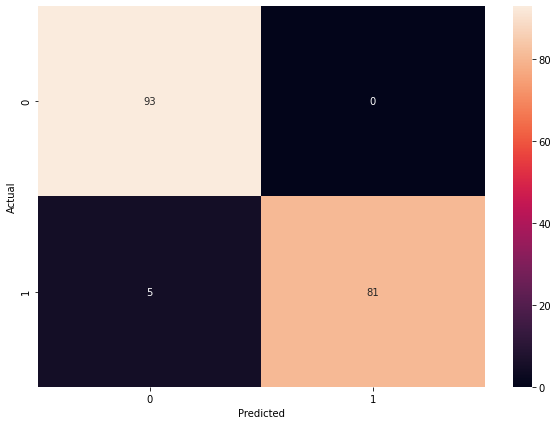

In [46]:
cm2 = confusion_matrix(y2_test, predictions3)

plt.figure(figsize=(10,7))
sn.heatmap(cm2, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [47]:
print('Accuracy is :', accuracy_score(y2_test, predictions3))
print('')
print('Classification report is : \n', classification_report(y2_test, predictions3))

Accuracy is : 0.9720670391061452

Classification report is : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        93
           1       1.00      0.94      0.97        86

    accuracy                           0.97       179
   macro avg       0.97      0.97      0.97       179
weighted avg       0.97      0.97      0.97       179



In [48]:
# Checking if variance of some features are multiple folds of the others
X2_var = np.var(X2_train, axis = 0)

X2_var

radius_mean                 14.645897
texture_mean                17.895234
perimeter_mean             695.569444
area_mean               159479.349548
smoothness_mean              0.000209
concavity_mean               0.007347
concave points_mean          0.001743
radius_se                    0.109145
texture_se                   0.259024
perimeter_se                 5.891398
area_se                   3349.774872
concave points_se            0.000038
radius_worst                27.530790
texture_worst               37.908863
perimeter_worst           1331.423158
area_worst              417490.652131
smoothness_worst             0.000617
concavity_worst              0.047180
concave points_worst         0.004758
symmetry_worst               0.005170
dtype: float64

In [49]:
# Checking to see if we need to standardize the sub dataset
StdS = StandardScaler() # SScaler = preprocessing.StandardScaler().fit(X_train)
Std_X2_train = StdS.fit_transform(X2_train) # Std_X_train = SScaler.transform(X_train)
Std_X2_test = StdS.transform(X2_test) # Std_X_test = SScaler.transform(X_test)

In [50]:
X2std_var = np.var(Std_X2_train, axis = 0)

X2std_var

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [51]:

model4 = LogisticRegression(solver='liblinear',multi_class='ovr')

model4.fit(Std_X2_train, y2_train)


predictions4 = model4.predict(Std_X2_test)

Text(69.0, 0.5, 'Actual')

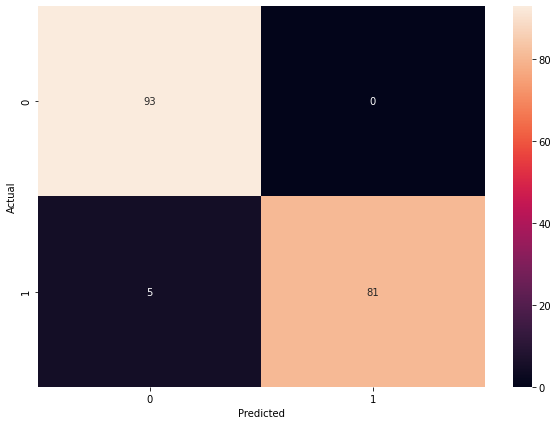

In [52]:
cm3 = confusion_matrix(y2_test, predictions4)

plt.figure(figsize=(10,7))
sn.heatmap(cm3, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [53]:
print('Accuracy is :', accuracy_score(y2_test, predictions4))
print('')
print('Classification report is : \n', classification_report(y2_test, predictions4))

Accuracy is : 0.9720670391061452

Classification report is : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        93
           1       1.00      0.94      0.97        86

    accuracy                           0.97       179
   macro avg       0.97      0.97      0.97       179
weighted avg       0.97      0.97      0.97       179



# Building a KNN classification model

The hyperparameters to tune for KNN are: the number of neighbors (n_neighbors), distance metrics (metric in [‘euclidean’, ‘manhattan’, ‘minkowski’]) for choosing the composition of the neighborhood. And then contribution of members of the neighborhood via different weightings (weights in [‘uniform’, ‘distance’]).

The code below is adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/, and edited for grid searching the key hyperparameters for KNeighborsClassifier on this breast cancer binary classification dataset.

In [54]:
# define models and parameters
model = KNeighborsClassifier()
n_neighbors = range(1, 21)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)

# summarize results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

0.957538 (0.021510) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.957538 (0.021510) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.950548 (0.024438) with: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
0.957538 (0.021510) with: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
0.951474 (0.020957) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.962663 (0.018189) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.941673 (0.023582) with: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
0.956605 (0.019528) with: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
0.933731 (0.024125) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.957068 (0.020050) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.933731 (0.026759) with: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'uniform'}
0.957

In [55]:
# This optimal combination is then used on the 75:25 % train:test data split

knn=KNeighborsClassifier(n_neighbors=19, metric = 'manhattan', weights = 'distance')
knn.fit(X_train,y_train)
predictionsa=knn.predict(X_test)
predictionsa

array([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0], dtype=int64)

Text(69.0, 0.5, 'Actual')

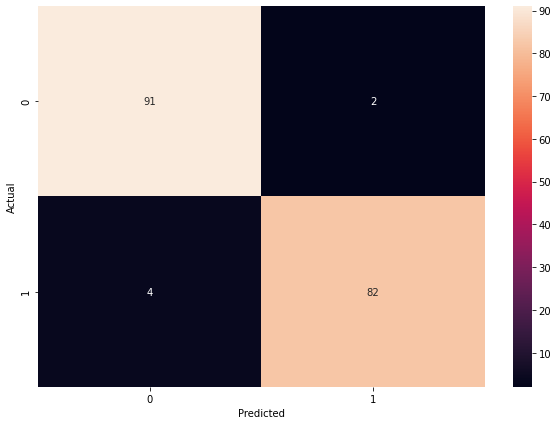

In [56]:
cma = confusion_matrix(y_test, predictionsa)

plt.figure(figsize=(10,7))
sn.heatmap(cma, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [57]:
print('Accuracy is :', accuracy_score(y_test, predictionsa))
print('')
print('Classification report is : \n', classification_report(y_test, predictionsa))

Accuracy is : 0.9664804469273743

Classification report is : 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        93
           1       0.98      0.95      0.96        86

    accuracy                           0.97       179
   macro avg       0.97      0.97      0.97       179
weighted avg       0.97      0.97      0.97       179



# Using the weights hyperparameter with the scaled dataset gives a very poor performance.
# To use the scaled data, I will try the Mean squared error (MSE) approach

In [58]:
MSEs = []
for k in range(1, 21):
    knn2 = KNeighborsClassifier(n_neighbors=k)
    knn2.fit(Std_X_train,y_train)
    predictions_k = knn2.predict(Std_X_test)
    MSEs.append(np.mean(predictions_k != y_test))

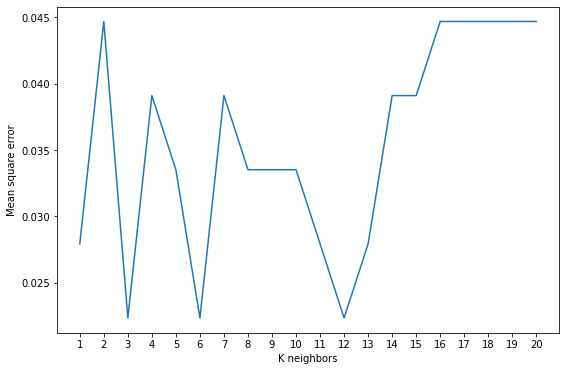

In [59]:
# Plot the K vs MSE values
fig, sub = plt.subplots(1, 1)
fig.set_size_inches(9, 6)
plt.plot(range(1,21), MSEs)
plt.xlabel('K neighbors')
plt.ylabel('Mean square error')
plt.xticks(range(1,21))
plt.show()

In [60]:
from sklearn.metrics import mean_squared_error

In [61]:
# With the built in MSE estimator from sklearn library
MSE2 = []
for k in range(1, 21):
    knn3 = KNeighborsClassifier(n_neighbors=k)
    knn3.fit(Std_X_train,y_train)
    predictions2_k = knn3.predict(Std_X_test)
    MSE2.append(mean_squared_error(y_test, predictions2_k))

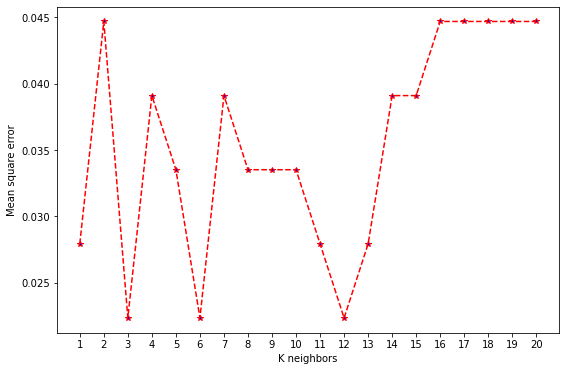

In [62]:
# Plot the feature importance
fig, sub = plt.subplots(1, 1)
fig.set_size_inches(9, 6)
plt.plot(range(1,21), MSE2, color='red',linestyle='--',
        marker='*', markersize=6, markerfacecolor='b')
plt.xlabel('K neighbors')
plt.ylabel('Mean square error')
plt.xticks(range(1,21))
plt.show()

From both curves,K values of 3, 6 and 12 give the lowest mean errors. While 2, 16, 17 , 18 give the highest mean errors.

In [63]:
# Trying a different approach (MSE) with the sacled dataset
k = [3, 6, 12, 18] # The last value is to test of the highest MSE K values
Accuracy = []
Confusion_matrix = []
for i in k:
    knn4 = KNeighborsClassifier(n_neighbors=i)
    knn4.fit(Std_X_train,y_train)
    predictions4 = knn4.predict(Std_X_test)
    Accuracy.append(accuracy_score(y_test, predictions4))
    Confusion_matrix.append(confusion_matrix(y_test, predictions4).ravel())

In [64]:
print([k, Accuracy])
print()
print('tn, fp, fn, tp =', Confusion_matrix)

[[3, 6, 12, 18], [0.9776536312849162, 0.9776536312849162, 0.9776536312849162, 0.9553072625698324]]

tn, fp, fn, tp = [array([90,  3,  1, 85], dtype=int64), array([92,  1,  3, 83], dtype=int64), array([92,  1,  3, 83], dtype=int64), array([91,  2,  6, 80], dtype=int64)]


In [65]:
# Adding the Manhattan distance metric
MSE3 = []
for k in range(1, 21):
    knn4 = KNeighborsClassifier(n_neighbors=k, metric = 'manhattan')
    knn4.fit(Std_X_train,y_train)
    predictions3_k = knn4.predict(Std_X_test)
    MSE3.append(mean_squared_error(y_test, predictions3_k))

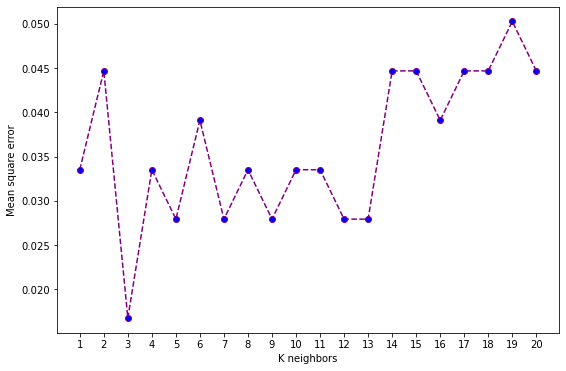

In [66]:
# Plot the feature importance
fig, sub = plt.subplots(1, 1)
fig.set_size_inches(9, 6)
plt.plot(range(1,21), MSE3, color='purple',linestyle='--',
        marker='o', markersize=6, markerfacecolor='b')
plt.xlabel('K neighbors')
plt.ylabel('Mean square error')
plt.xticks(range(1,21))
plt.show()